# Detecting Fake News - Modeling Notebook

In [1]:
#import libraries
import pandas as pd
import numpy as np
import json
import requests
import string
import re
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import cross_val_score, cross_val_predict, GridSearchCV

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from imblearn.datasets import make_imbalance

from imblearn.pipeline import Pipeline as smote_pipeline
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

np.random.seed(7)

## Importing Final Dataframe from EDA Notebook

In [2]:
df = pickle.load(open("Master_df.p", 'rb'))
df

,title,text,label,source,text_cleaned,text_cleaned_tokenized,text_tokenized_string,text_pos_lemmatized,text_snowball_stemmed,text_porter_stemmed_for_visual,text_porter_stemmed,text_lancaster_stemmed,text_pos_tagged,word_length
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,0,ISOT,head conservative republican faction us congre...,"[head, conservative, republican, faction, us, ...",head conservative republican faction us congre...,head conservative republican faction us congre...,head conserv republican faction us congress vo...,"[head, conserv, republican, faction, us, congr...",head conserv republican faction us congress vo...,head conserv republ fact us congress vot mon h...,"[(head, NN), (conservative, JJ), (republican, ...",405
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,0,ISOT,transgender people allowed first time enlist u...,"[transgender, people, allowed, first, time, en...",transgender people allowed first time enlist u...,transgender people allow first time enlist us ...,transgend peopl allow first time enlist us mil...,"[transgend, peopl, allow, first, time, enlist,...",transgend peopl allow first time enlist us mil...,transgend peopl allow first tim enl us milit s...,"[(transgender, NN), (people, NNS), (allowed, V...",343
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,0,ISOT,special counsel investigation links russia pre...,"[special, counsel, investigation, links, russi...",special counsel investigation links russia pre...,special counsel investigation link russia pres...,special counsel investig link russia presid tr...,"[special, counsel, investig, link, russia, pre...",special counsel investig link russia presid tr...,spec counsel investig link russ presid trump e...,"[(special, JJ), (counsel, NN), (investigation,...",243
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,0,ISOT,trump campaign adviser george papadopoulos aus...,"[trump, campaign, adviser, george, papadopoulo...",trump campaign adviser george papadopoulos aus...,trump campaign adviser george papadopoulos aus...,trump campaign advis georg papadopoulo austral...,"[trump, campaign, advis, georg, papadopoulo, a...",trump campaign advis georg papadopoulo austral...,trump campaign adv georg papadopoulo aust dipl...,"[(trump, NN), (campaign, NN), (adviser, NN), (...",214
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,0,ISOT,president donald trump called us postal servic...,"[president, donald, trump, called, us, postal,...",president donald trump called us postal servic...,president donald trump call us postal service ...,presid donald trump call us postal servic char...,"[presid, donald, trump, call, us, postal, serv...",presid donald trump call us postal servic char...,presid donald trump cal us post serv charg muc...,"[(president, NN), (donald, NN), (trump, NN), (...",466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72028,Rapper T.I.: Trump a ’Poster Child For White S...,Rapper T. I. unloaded on black celebrities who...,0,Kaggle,rapper unloaded black celebrities met donald t...,"[rapper, unloaded, black, celebrities, met, do...",rapper unloaded black celebrities met donald t...,rapper unload black celebrity meet donald trum...,rapper unload black celebr met donald trump el...,"[rapper, unload, black, celebr, met, donald, t...",rapper unload black celebr met donald trump el...,rap unload black celebr met donald trump elect...,"[(rapper, NN), (unloaded, VBD), (black, JJ), (...",161
72029,"N.F.L. Playoffs: Schedule, Matchups and Odds -...",When the Green Bay Packers lost to the Washing...,0,Kaggle,green bay packers lost washington redskins wee...,"[green, bay, packers, lost, washington, redski...",green bay packers lost washington redskins wee...,green bay packer lose 

# Managing class imbalance

Let's get a refresher on the number of observations we have in each class:

In [3]:
label_counts = df['label'].value_counts()
label_counts

1    36461
0    34975
Name: label, dtype: int64

Great. Let's declare our X and y in preparation for train/test split. We'll need to explore which data field produces the best results, so let's pull the different text fields we have from our EDA:

In [4]:
X = df[['text_cleaned', 'text_tokenized_string', 'title', 'label', 'text_pos_lemmatized', 'text_snowball_stemmed', 
        'text_porter_stemmed', 'text_lancaster_stemmed']]
y = df['label']

However, before we can split our data into training/testing sets, we need to make an imbalanced dataset to reflect the "real-world" distribution of Real/Fake news.

According to VOX, in 2020, **17%** of engagement with the 100 top-performing news sources on social media was dubious. <br> https://www.vox.com/policy-and-politics/2020/12/22/22195488/fake-news-social-media-2020  

Based on this, I decided to aim for an 80/20 split on Real/Fake news, in order to best train my model. Let's do this below:

In [5]:
#declare the ratio of Real:Fake news
ratio=4

#make imbalanced dataframes
x_imb, y_imb = make_imbalance(X, y, sampling_strategy={'1': label_counts.max() // ratio}, random_state=7)

In [6]:
#preview our new imbalanced data
y_imb.value_counts()

0    34975
1     9115
Name: label, dtype: int64

With this imbalanced dataset, we can now create our train/test splits for the modeling to come:

In [7]:
X_train, X_test, y_train, y_test = train_test_split(x_imb, y_imb, stratify=y_imb, random_state=7)

In [8]:
#preview training set class counts
y_train.value_counts()

0    26231
1     6836
Name: label, dtype: int64

# Model Evaluation Tracking

One last step before jumping into the modeling is to consider how to store and compare the results of my model. Let's create a function to run the models and calculate/save evaluation metrics.

In [9]:
#create a dataframe with n_obs in each class. Used in evaluating the accuracy/precisions/recall/etc. of our models.
df_value_counts = pd.DataFrame(y_train.value_counts())
df_value_counts

,label
0,26231
1,6836


In [10]:
#create a datafarme to track the various model performances
df_model_results = pd.DataFrame(columns=['Model Type', 'Modeled On', 'CV Score', 'False Negative Rate','True Positive Rate', 
                                         'False Positive Rate', 'True Negative Rate', 'Precision', 'Recall', 'F1 Score'])
df_model_results

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score


In [11]:
#define a function to run a pipeline on a specified variable, and store the results under the specified model name
def evaluate_store_results(pipeline, variable, model_name):
    #break encapsulation
    global df_model_results
    
    #cross validate with 5 folds and make predictions on training set
    cv_results = np.median(cross_val_score(pipeline, X_train[variable], y_train, cv=5))
    y_pred = cross_val_predict(pipeline, X_train[variable], y_train, cv=5)
    
    #confusion matrix
    c_matrix = confusion_matrix(y_train, y_pred)
    
    #False Negative Rate - when a news article is FAKE, how often does the model predict this to be REAl?
    FNR = c_matrix[1,0] / df_value_counts.iloc[1]['label']

    #True Positive Rate - when a news article is FAKE, how often does the model correctly predict this?
    TPR = c_matrix[1,1] / df_value_counts.iloc[1]['label']

    #False Positive Rate - when a news article is REAL, how often does the model predict it to be FAKE?
    FPR = c_matrix[0,1] / df_value_counts.iloc[0]['label']

    #True Negative Rate - when a news article is REAL, how often does the model predict it to be REAL?
    TNR = c_matrix[0,0] / df_value_counts.iloc[0]['label']

    #Precision - What proportion of FAKE predictions were actually correct?
    precision = c_matrix[1,1] / (c_matrix[0,1] + c_matrix[1,1])

    #Recall - what proportion of actual FAKE articles were identified?
    recall = c_matrix[1,1] / (c_matrix[1,0] + c_matrix[1,1])

    #F1 score
    f1 = 2*(precision*recall)/(precision+recall)
    
    #save model results
    model_results = {
    'Model Type': model_name,
    'Modeled On': variable, 
    'CV Score': cv_results,
    'False Negative Rate': FNR,
    'True Positive Rate': TPR,
    'False Positive Rate': FPR,
    'True Negative Rate': TNR,
    'Precision': precision,
    'Recall': recall,
    'F1 Score': f1}

    #append model results
    df_model_results = df_model_results.append(model_results, ignore_index=True)
    return df_model_results

Perfect! Now let's jump into modeling.

# Modeling

## Narrowing down the algorithms to explore

The first step in my modeling process was to narrow down which algorithms would provide the best results. To do this, I decided to run a number of different models on the `text_cleaned` field.

### Baseline Model - `text_cleaned`

In [12]:
pipeline_base = Pipeline([('Vectorizer', TfidfVectorizer()),
              ('Dummy Classifier', DummyClassifier(strategy='most_frequent'))])

In [13]:
evaluate_store_results(pipeline_base, 'text_cleaned', 'Baseline Model')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.0,0.0,0.0,1.0,NaN,0.0,NaN


79.3% accuracy, as expected due to the 80/20 split we manufactured earlier.

## Multinomial Naive Bayes - `text_cleaned`

In [14]:
pipeline_MNB = Pipeline([('Vectorizer', TfidfVectorizer()),
              ('Multinomial Naive Bayes', MultinomialNB())])

In [15]:
evaluate_store_results(pipeline_MNB, 'text_cleaned', 'Multinomial Naive Bayes')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797097,0.981129,0.018871,0.000038,0.999962,0.992308,0.018871,0.037037


## Random Forest Classifier - `text_cleaned`

In [16]:
from sklearn.ensemble import RandomForestClassifier

pipeline_RFC = Pipeline([('Vectorizer', TfidfVectorizer()),
              ('Random Forest Classifier', RandomForestClassifier())])

In [17]:
evaluate_store_results(pipeline_RFC, 'text_cleaned', 'Random Forest Classifier')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797097,0.981129,0.018871,0.000038,0.999962,0.992308,0.018871,0.037037
2,Random Forest Classifier,text_cleaned,0.865286,0.635313,0.364687,0.003164,0.996836,0.967780,0.364687,0.529749


## Passive Aggressive Classifier `text_cleaned`

In [18]:
pipeline_PAC = Pipeline([('Vectorizer', TfidfVectorizer()),
              ('Passive Aggressive Classifier', PassiveAggressiveClassifier())])

In [19]:
evaluate_store_results(pipeline_PAC, 'text_cleaned', 'Passive Aggressive Classifier')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797097,0.981129,0.018871,0.000038,0.999962,0.992308,0.018871,0.037037
2,Random Forest Classifier,text_cleaned,0.865286,0.635313,0.364687,0.003164,0.996836,0.967780,0.364687,0.529749
3,Passive Aggressive Classifier,text_cleaned,0.935591,0.193827,0.806173,0.030117,0.969883,0.874623,0.806173,0.839004


## XGBoost `text_cleaned`

In [20]:
pipeline_XGB = Pipeline([('Vectorizer', TfidfVectorizer()),
              ('XGBoost', XGBClassifier())])

In [21]:
evaluate_store_results(pipeline_XGB, 'text_cleaned', 'XGBoost')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797097,0.981129,0.018871,0.000038,0.999962,0.992308,0.018871,0.037037
2,Random Forest Classifier,text_cleaned,0.865286,0.635313,0.364687,0.003164,0.996836,0.967780,0.364687,0.529749
3,Passive Aggressive Classifier,text_cleaned,0.935591,0.193827,0.806173,0.030117,0.969883,0.874623,0.806173,0.839004
4,XGBoost,text_cleaned,0.920611,0.281012,0.718988,0.026533,0.973467,0.875958,0.718988,0.789749


## ADABoost `text_cleaned`

In [22]:
pipeline_adaB = Pipeline([('Vectorizer', TfidfVectorizer()),
              ('ADABoost', AdaBoostClassifier())])

evaluate_store_results(pipeline_adaB, 'text_cleaned', 'AdaBoost')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797097,0.981129,0.018871,0.000038,0.999962,0.992308,0.018871,0.037037
2,Random Forest Classifier,text_cleaned,0.865286,0.635313,0.364687,0.003164,0.996836,0.967780,0.364687,0.529749
3,Passive Aggressive Classifier,text_cleaned,0.935591,0.193827,0.806173,0.030117,0.969883,0.874623,0.806173,0.839004
4,XGBoost,text_cleaned,0.920611,0.281012,0.718988,0.026533,0.973467,0.875958,0.718988,0.789749
5,AdaBoost,text_cleaned,0.853924,0.506290,0.493710,0.051618,0.948382,0.713682,0.493710,0.583658


## Extra Trees Classifier `text_cleaned`

In [23]:
pipeline_XTC = Pipeline([('Vectorizer', TfidfVectorizer()),
              ('ADABoost', ExtraTreesClassifier())])

evaluate_store_results(pipeline_XTC, 'text_cleaned', 'Extra Tree Classifier')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797097,0.981129,0.018871,0.000038,0.999962,0.992308,0.018871,0.037037
2,Random Forest Classifier,text_cleaned,0.865286,0.635313,0.364687,0.003164,0.996836,0.967780,0.364687,0.529749
3,Passive Aggressive Classifier,text_cleaned,0.935591,0.193827,0.806173,0.030117,0.969883,0.874623,0.806173,0.839004
4,XGBoost,text_cleaned,0.920611,0.281012,0.718988,0.026533,0.973467,0.875958,0.718988,0.789749
5,AdaBoost,text_cleaned,0.853924,0.506290,0.493710,0.051618,0.948382,0.713682,0.493710,0.583658
6,Extra Tree Classifier,text_cleaned,0.861031,0.658865,0.341135,0.001258,0.998742,0.986047,0.341135,0.506901


Looks like XGBoost and Passive Aggressive Classifier are the best algorithms. Let's focus on these 2 algorithms moving forward.

Next, let's look to see which data (text) field is the best for predicting whether a news article is fake or not.

## Identifying which data field is the best

### Modeling - `title`

In [24]:
evaluate_store_results(pipeline_PAC, 'title', 'Passive Aggressive Classifier')
evaluate_store_results(pipeline_XGB, 'title', 'XGBoost')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797097,0.981129,0.018871,0.000038,0.999962,0.992308,0.018871,0.037037
2,Random Forest Classifier,text_cleaned,0.865286,0.635313,0.364687,0.003164,0.996836,0.967780,0.364687,0.529749
3,Passive Aggressive Classifier,text_cleaned,0.935591,0.193827,0.806173,0.030117,0.969883,0.874623,0.806173,0.839004
4,XGBoost,text_cleaned,0.920611,0.281012,0.718988,0.026533,0.973467,0.875958,0.718988,0.789749
5,AdaBoost,text_cleaned,0.853924,0.506290,0.493710,0.051618,0.948382,0.713682,0.493710,0.583658
6,Extra Tree Classifier,text_cleaned,0.861031,0.658865,0.341135,0.001258,0.998742,0.986047,0.341135,0.506901
7,Passive Aggressive Classifier,title,0.897793,0.262580,0.737420,0.059357,0.940643,0.764019,0.737420,0.750484
8,XGBoost,title,0.903992,0.361176,0.638824,0.025809,0.974191,0.865781,0.638824,0.735185


### Modeling - `text_tokenized_string`

In [25]:
evaluate_store_results(pipeline_PAC, 'text_tokenized_string', 'Passive Aggressive Classifier')
evaluate_store_results(pipeline_XGB, 'text_tokenized_string', 'XGBoost')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797097,0.981129,0.018871,0.000038,0.999962,0.992308,0.018871,0.037037
2,Random Forest Classifier,text_cleaned,0.865286,0.635313,0.364687,0.003164,0.996836,0.967780,0.364687,0.529749
3,Passive Aggressive Classifier,text_cleaned,0.935591,0.193827,0.806173,0.030117,0.969883,0.874623,0.806173,0.839004
4,XGBoost,text_cleaned,0.920611,0.281012,0.718988,0.026533,0.973467,0.875958,0.718988,0.789749
5,AdaBoost,text_cleaned,0.853924,0.506290,0.493710,0.051618,0.948382,0.713682,0.493710,0.583658
6,Extra Tree Classifier,text_cleaned,0.861031,0.658865,0.341135,0.001258,0.998742,0.986047,0.341135,0.506901
7,Passive Aggressive Classifier,title,0.897793,0.262580,0.737420,0.059357,0.940643,0.764019,0.737420,0.750484
8,XGBoost,title,0.903992,0.361176,0.638824,0.025809,0.974191,0.865781,0.638824,0.735185
9,Passive Aggressive Classifier,text_tokenized_string,0.936186,0.195290,0.804710,0.030498,0.969502,0.873036,0.804710,0.837482


### Modeling - `text_pos_lemmatized`

In [26]:
evaluate_store_results(pipeline_PAC, 'text_pos_lemmatized', 'Passive Aggressive Classifier')
evaluate_store_results(pipeline_XGB, 'text_pos_lemmatized', 'XGBoost')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797097,0.981129,0.018871,0.000038,0.999962,0.992308,0.018871,0.037037
2,Random Forest Classifier,text_cleaned,0.865286,0.635313,0.364687,0.003164,0.996836,0.967780,0.364687,0.529749
3,Passive Aggressive Classifier,text_cleaned,0.935591,0.193827,0.806173,0.030117,0.969883,0.874623,0.806173,0.839004
4,XGBoost,text_cleaned,0.920611,0.281012,0.718988,0.026533,0.973467,0.875958,0.718988,0.789749
5,AdaBoost,text_cleaned,0.853924,0.506290,0.493710,0.051618,0.948382,0.713682,0.493710,0.583658
6,Extra Tree Classifier,text_cleaned,0.861031,0.658865,0.341135,0.001258,0.998742,0.986047,0.341135,0.506901
7,Passive Aggressive Classifier,title,0.897793,0.262580,0.737420,0.059357,0.940643,0.764019,0.737420,0.750484
8,XGBoost,title,0.903992,0.361176,0.638824,0.025809,0.974191,0.865781,0.638824,0.735185
9,Passive Aggressive Classifier,text_tokenized_string,0.936186,0.195290,0.804710,0.030498,0.969502,0.873036,0.804710,0.837482


### Modeling - `text_snowball_stemmed`

In [27]:
evaluate_store_results(pipeline_PAC, 'text_snowball_stemmed', 'Passive Aggressive Classifier')
evaluate_store_results(pipeline_XGB, 'text_snowball_stemmed', 'XGBoost')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797097,0.981129,0.018871,0.000038,0.999962,0.992308,0.018871,0.037037
2,Random Forest Classifier,text_cleaned,0.865286,0.635313,0.364687,0.003164,0.996836,0.967780,0.364687,0.529749
3,Passive Aggressive Classifier,text_cleaned,0.935591,0.193827,0.806173,0.030117,0.969883,0.874623,0.806173,0.839004
4,XGBoost,text_cleaned,0.920611,0.281012,0.718988,0.026533,0.973467,0.875958,0.718988,0.789749
5,AdaBoost,text_cleaned,0.853924,0.506290,0.493710,0.051618,0.948382,0.713682,0.493710,0.583658
6,Extra Tree Classifier,text_cleaned,0.861031,0.658865,0.341135,0.001258,0.998742,0.986047,0.341135,0.506901
7,Passive Aggressive Classifier,title,0.897793,0.262580,0.737420,0.059357,0.940643,0.764019,0.737420,0.750484
8,XGBoost,title,0.903992,0.361176,0.638824,0.025809,0.974191,0.865781,0.638824,0.735185
9,Passive Aggressive Classifier,text_tokenized_string,0.936186,0.195290,0.804710,0.030498,0.969502,0.873036,0.804710,0.837482


### Modeling - `text_porter_stemmed`

In [28]:
evaluate_store_results(pipeline_PAC, 'text_porter_stemmed', 'Passive Aggressive Classifier')
evaluate_store_results(pipeline_XGB, 'text_porter_stemmed', 'XGBoost')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797097,0.981129,0.018871,0.000038,0.999962,0.992308,0.018871,0.037037
2,Random Forest Classifier,text_cleaned,0.865286,0.635313,0.364687,0.003164,0.996836,0.967780,0.364687,0.529749
3,Passive Aggressive Classifier,text_cleaned,0.935591,0.193827,0.806173,0.030117,0.969883,0.874623,0.806173,0.839004
4,XGBoost,text_cleaned,0.920611,0.281012,0.718988,0.026533,0.973467,0.875958,0.718988,0.789749
5,AdaBoost,text_cleaned,0.853924,0.506290,0.493710,0.051618,0.948382,0.713682,0.493710,0.583658
6,Extra Tree Classifier,text_cleaned,0.861031,0.658865,0.341135,0.001258,0.998742,0.986047,0.341135,0.506901
7,Passive Aggressive Classifier,title,0.897793,0.262580,0.737420,0.059357,0.940643,0.764019,0.737420,0.750484
8,XGBoost,title,0.903992,0.361176,0.638824,0.025809,0.974191,0.865781,0.638824,0.735185
9,Passive Aggressive Classifier,text_tokenized_string,0.936186,0.195290,0.804710,0.030498,0.969502,0.873036,0.804710,0.837482


### Modeling - `text_lancaster_stemmed`

In [29]:
evaluate_store_results(pipeline_PAC, 'text_lancaster_stemmed', 'Passive Aggressive Classifier')
evaluate_store_results(pipeline_XGB, 'text_lancaster_stemmed', 'XGBoost')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797097,0.981129,0.018871,0.000038,0.999962,0.992308,0.018871,0.037037
2,Random Forest Classifier,text_cleaned,0.865286,0.635313,0.364687,0.003164,0.996836,0.967780,0.364687,0.529749
3,Passive Aggressive Classifier,text_cleaned,0.935591,0.193827,0.806173,0.030117,0.969883,0.874623,0.806173,0.839004
4,XGBoost,text_cleaned,0.920611,0.281012,0.718988,0.026533,0.973467,0.875958,0.718988,0.789749
5,AdaBoost,text_cleaned,0.853924,0.506290,0.493710,0.051618,0.948382,0.713682,0.493710,0.583658
6,Extra Tree Classifier,text_cleaned,0.861031,0.658865,0.341135,0.001258,0.998742,0.986047,0.341135,0.506901
7,Passive Aggressive Classifier,title,0.897793,0.262580,0.737420,0.059357,0.940643,0.764019,0.737420,0.750484
8,XGBoost,title,0.903992,0.361176,0.638824,0.025809,0.974191,0.865781,0.638824,0.735185
9,Passive Aggressive Classifier,text_tokenized_string,0.936186,0.195290,0.804710,0.030498,0.969502,0.873036,0.804710,0.837482


Let's see the best performing model (index #) for each evaluation metric.

In [30]:
print('Highest CV Score:', df_model_results['CV Score'].idxmax())
print('Lowest False Negative Rate:', 
      df_model_results[df_model_results['False Negative Rate'] != 0]['False Negative Rate'].idxmin())
print('Lowest False Positive Rate:', 
      df_model_results[df_model_results['False Positive Rate'] != 0]['False Negative Rate'].idxmin())
print('Highest F1 Score:', df_model_results['F1 Score'].idxmax())
print('Highest Recall:', df_model_results['Recall'].idxmax())

Highest CV Score: 9
Lowest False Negative Rate: 3
Lowest False Positive Rate: 3
Highest F1 Score: 3
Highest Recall: 3


Model results show that `text_tokenized_string`, where we manually removed stop words had the highest cross-validation accuracy score. However, when we compare the False Negative Rate to the `text_cleaned` field, we discover that `text_cleaned` had a slightly lower rate. Please refer to results in index 3 and index 9.

Due to the nature of my problem, I wanted to put an emphasis on keeping the False Negative Rate to be as low as possible (when an article is fake, minimizing the number of times my model predicts the article to be real).

Now that we've also narrowed down the data field, as well as which algorithms to explore, let's first do a GridSearch to optimize our vectorizer.

Let's recall our list of words to remove from the EDA notebook:

In [31]:
#removing stopwords
words = stopwords.words("english")
custom_words = ['’', '“', '”', '—', '‘', 'st', 'say', 'said', 'on', 'told', 're', 'would', 'could', 'monday', 'tuesday', 
                'wednesday', 'thursday', 'friday', 'saturday', 'sunday', 'two', '–', 'mr', 'mrs', 'ms', 'one', 'also', 'like',
                'century wire', 'wire', '21wire', 'featured image', 'com', 'https', 'www', 'image via', 'via', 'image', 
                'st century', 'twitter', 'on', 'breitbart', 'read more', 'reuters', 'follow', 'flickr', 'getty', 'please', 
               'watch', 'video', 'january', 'feburary', 'march', 'april', 'may', 'june', 'july', 'august', 'september', 
               'october', 'november', 'december', 'images', 'getty images', 'featured']

for i in custom_words:
    words.append(i)

#remove floating letters
alphabet = string.ascii_lowercase
for i in alphabet:
    words.append(i)

#remove additional floating characters
words_split = []

for text in df['text_cleaned_tokenized']:
    words_split += text

list_words_one_character = []

for word in words_split:
    if len(word) == 1:
        list_words_one_character.append(word)
        
display(set(list_words_one_character))

for i in list_words_one_character:
    words.append(i)
    
words = set(words)

set()

## Optimizing TFIDFVectorizer

In [32]:
#Optimizing vectorizer parameters for PAC
pipeline_PAC = Pipeline([('Vectorizer', TfidfVectorizer()),
              ('Passive Aggressive Classifier', PassiveAggressiveClassifier())])

param_grid = {
    'Vectorizer__stop_words': [None, words],
    'Vectorizer__ngram_range': [(1,1), (1,2), (2,2)]
}

grid_search = GridSearchCV(pipeline_PAC, param_grid)

grid_search.fit(X_train['text_cleaned'], y_train)
grid_search.best_params_

{'Vectorizer__ngram_range': (1, 2), 'Vectorizer__stop_words': None}

In [33]:
#Optimizing vectorizer parameters for XGB
pipeline_XGB = Pipeline([('Vectorizer', TfidfVectorizer()),
              ('XGBoost', XGBClassifier(verbosity=0))])

param_grid = {
    'Vectorizer__stop_words': [None, words],
    'Vectorizer__ngram_range': [(1,1), (1,2), (2,2)]
}

grid_search = GridSearchCV(pipeline_XGB, param_grid)

grid_search.fit(X_train['text_cleaned'], y_train)
grid_search.best_params_

{'Vectorizer__ngram_range': (1, 2),
 'Vectorizer__stop_words': {'21wire',
  'a',
  'about',
  'above',
  'after',
  'again',
  'against',
  'ain',
  'all',
  'also',
  'am',
  'an',
  'and',
  'any',
  'april',
  'are',
  'aren',
  "aren't",
  'as',
  'at',
  'august',
  'b',
  'be',
  'because',
  'been',
  'before',
  'being',
  'below',
  'between',
  'both',
  'breitbart',
  'but',
  'by',
  'c',
  'can',
  'century wire',
  'com',
  'could',
  'couldn',
  "couldn't",
  'd',
  'december',
  'did',
  'didn',
  "didn't",
  'do',
  'does',
  'doesn',
  "doesn't",
  'doing',
  'don',
  "don't",
  'down',
  'during',
  'e',
  'each',
  'f',
  'featured',
  'featured image',
  'feburary',
  'few',
  'flickr',
  'follow',
  'for',
  'friday',
  'from',
  'further',
  'g',
  'getty',
  'getty images',
  'h',
  'had',
  'hadn',
  "hadn't",
  'has',
  'hasn',
  "hasn't",
  'have',
  'haven',
  "haven't",
  'having',
  'he',
  'her',
  'here',
  'hers',
  'herself',
  'him',
  'himself',
  'h

It looks like having unigrams and bigrams in our vectorizer produces the best results for both algorithms. However, it looks like the PAC algorithm performs best when no stop words are removed, whereas the XGBoost algorithm performs best when stop words are removed. Let's run these models and save the results.

In [34]:
pipeline_PAC = Pipeline([('Vectorizer', TfidfVectorizer(stop_words=None, ngram_range=(1,2))),
              ('Passive Aggressive Classifier', PassiveAggressiveClassifier())])
evaluate_store_results(pipeline_PAC, 'text_cleaned', 'TFIDF_optimal_PAC')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797097,0.981129,0.018871,0.000038,0.999962,0.992308,0.018871,0.037037
2,Random Forest Classifier,text_cleaned,0.865286,0.635313,0.364687,0.003164,0.996836,0.967780,0.364687,0.529749
3,Passive Aggressive Classifier,text_cleaned,0.935591,0.193827,0.806173,0.030117,0.969883,0.874623,0.806173,0.839004
4,XGBoost,text_cleaned,0.920611,0.281012,0.718988,0.026533,0.973467,0.875958,0.718988,0.789749
5,AdaBoost,text_cleaned,0.853924,0.506290,0.493710,0.051618,0.948382,0.713682,0.493710,0.583658
6,Extra Tree Classifier,text_cleaned,0.861031,0.658865,0.341135,0.001258,0.998742,0.986047,0.341135,0.506901
7,Passive Aggressive Classifier,title,0.897793,0.262580,0.737420,0.059357,0.940643,0.764019,0.737420,0.750484
8,XGBoost,title,0.903992,0.361176,0.638824,0.025809,0.974191,0.865781,0.638824,0.735185
9,Passive Aggressive Classifier,text_tokenized_string,0.936186,0.195290,0.804710,0.030498,0.969502,0.873036,0.804710,0.837482


In [35]:
pipeline_XGB = Pipeline([('Vectorizer', TfidfVectorizer(stop_words=words, ngram_range=(1,2))),
              ('XGBoost', XGBClassifier())])
evaluate_store_results(pipeline_XGB, 'text_cleaned', 'TFIDF_optimal_XGB')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797097,0.981129,0.018871,0.000038,0.999962,0.992308,0.018871,0.037037
2,Random Forest Classifier,text_cleaned,0.865286,0.635313,0.364687,0.003164,0.996836,0.967780,0.364687,0.529749
3,Passive Aggressive Classifier,text_cleaned,0.935591,0.193827,0.806173,0.030117,0.969883,0.874623,0.806173,0.839004
4,XGBoost,text_cleaned,0.920611,0.281012,0.718988,0.026533,0.973467,0.875958,0.718988,0.789749
5,AdaBoost,text_cleaned,0.853924,0.506290,0.493710,0.051618,0.948382,0.713682,0.493710,0.583658
6,Extra Tree Classifier,text_cleaned,0.861031,0.658865,0.341135,0.001258,0.998742,0.986047,0.341135,0.506901
7,Passive Aggressive Classifier,title,0.897793,0.262580,0.737420,0.059357,0.940643,0.764019,0.737420,0.750484
8,XGBoost,title,0.903992,0.361176,0.638824,0.025809,0.974191,0.865781,0.638824,0.735185
9,Passive Aggressive Classifier,text_tokenized_string,0.936186,0.195290,0.804710,0.030498,0.969502,0.873036,0.804710,0.837482


## Optimizing XGBoost and Passive Aggressive Classifier

Now, let's do a GridSearch to maximize our XGBoost and PAC parameters.

In [36]:
pipeline_PAC = Pipeline([('Vectorizer', TfidfVectorizer(stop_words=None, ngram_range=(1,2))),
              ('Passive Aggressive Classifier', PassiveAggressiveClassifier())])

param_grid = {
    'Passive Aggressive Classifier__C': [.01, .1, 1],
    'Passive Aggressive Classifier__max_iter': [100, 500, 1000],
    'Passive Aggressive Classifier__loss': ['hinge', 'squared_hinge']
}

grid_search = GridSearchCV(pipeline_PAC, param_grid)

grid_search.fit(X_train['text_cleaned'], y_train)

grid_search.best_params_

{'Passive Aggressive Classifier__C': 0.1,
 'Passive Aggressive Classifier__loss': 'hinge',
 'Passive Aggressive Classifier__max_iter': 1000}

In [37]:
pipeline_XGB = Pipeline([('Vectorizer', TfidfVectorizer(stop_words=words, ngram_range=(1,2))),
              ('XGBoost', XGBClassifier())])



param_grid = {
    'XGBoost__booster': ['gbtree', 'gblinear', 'dart'],
    'XGBoost__max_depth': [3, 6, 9]
}

grid_search = GridSearchCV(pipeline_XGB, param_grid)

grid_search.fit(X_train['text_cleaned'], y_train)

grid_search.best_params_

{'XGBoost__booster': 'gbtree', 'XGBoost__max_depth': 9}

For our PAC model, the best parameteres are C:0.1, loss='hinge', max_iter=1000.<br>
For our XGBoost model, the best parameters are: booster = gbtree, max_depth=9.

In [38]:
#store results
pipeline_PAC = Pipeline([('Vectorizer', TfidfVectorizer(stop_words=None, ngram_range=(1,2))),
              ('Passive Aggressive Classifier', PassiveAggressiveClassifier(C=.1, loss='hinge', max_iter=1000))])
evaluate_store_results(pipeline_PAC, 'text_cleaned', 'TFIDF_optimal_PAC_optimal')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797097,0.981129,0.018871,0.000038,0.999962,0.992308,0.018871,0.037037
2,Random Forest Classifier,text_cleaned,0.865286,0.635313,0.364687,0.003164,0.996836,0.967780,0.364687,0.529749
3,Passive Aggressive Classifier,text_cleaned,0.935591,0.193827,0.806173,0.030117,0.969883,0.874623,0.806173,0.839004
4,XGBoost,text_cleaned,0.920611,0.281012,0.718988,0.026533,0.973467,0.875958,0.718988,0.789749
5,AdaBoost,text_cleaned,0.853924,0.506290,0.493710,0.051618,0.948382,0.713682,0.493710,0.583658
6,Extra Tree Classifier,text_cleaned,0.861031,0.658865,0.341135,0.001258,0.998742,0.986047,0.341135,0.506901
7,Passive Aggressive Classifier,title,0.897793,0.262580,0.737420,0.059357,0.940643,0.764019,0.737420,0.750484
8,XGBoost,title,0.903992,0.361176,0.638824,0.025809,0.974191,0.865781,0.638824,0.735185
9,Passive Aggressive Classifier,text_tokenized_string,0.936186,0.195290,0.804710,0.030498,0.969502,0.873036,0.804710,0.837482


In [39]:
#store results
pipeline_XGB = Pipeline([('Vectorizer', TfidfVectorizer(stop_words=words, ngram_range=(1,2))),
              ('XGBoost', XGBClassifier(booster='gbtree', max_depth=9))])
evaluate_store_results(pipeline_XGB, 'text_cleaned', 'TFIDF_optimal_XGB_optimal')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797097,0.981129,0.018871,0.000038,0.999962,0.992308,0.018871,0.037037
2,Random Forest Classifier,text_cleaned,0.865286,0.635313,0.364687,0.003164,0.996836,0.967780,0.364687,0.529749
3,Passive Aggressive Classifier,text_cleaned,0.935591,0.193827,0.806173,0.030117,0.969883,0.874623,0.806173,0.839004
4,XGBoost,text_cleaned,0.920611,0.281012,0.718988,0.026533,0.973467,0.875958,0.718988,0.789749
5,AdaBoost,text_cleaned,0.853924,0.506290,0.493710,0.051618,0.948382,0.713682,0.493710,0.583658
6,Extra Tree Classifier,text_cleaned,0.861031,0.658865,0.341135,0.001258,0.998742,0.986047,0.341135,0.506901
7,Passive Aggressive Classifier,title,0.897793,0.262580,0.737420,0.059357,0.940643,0.764019,0.737420,0.750484
8,XGBoost,title,0.903992,0.361176,0.638824,0.025809,0.974191,0.865781,0.638824,0.735185
9,Passive Aggressive Classifier,text_tokenized_string,0.936186,0.195290,0.804710,0.030498,0.969502,0.873036,0.804710,0.837482


## Optimizing up-sampling and down-sampling

Now let's see if up-sampling or down-sampling will improve results:

In [40]:
smote_pipeline_PAC = smote_pipeline([('Vectorizer', TfidfVectorizer(stop_words=None, ngram_range=(1,2))),
                                     ('SMOTE', SMOTE()),
                                     ('Passive Aggressive Classifier', PassiveAggressiveClassifier(C=.1, loss='hinge', 
                                                                                                   max_iter=1000
                                                                                                  ))])

param_grid = {
    'SMOTE__sampling_strategy': [1, 1/2, 1/3, 1/4, 1/5, 1/8]
}

grid_search = GridSearchCV(smote_pipeline_PAC, param_grid)

grid_search.fit(X_train['text_cleaned'], y_train)

GridSearchCV(estimator=Pipeline(steps=[('Vectorizer',
                                        TfidfVectorizer(ngram_range=(1, 2))),
                                       ('SMOTE', SMOTE()),
                                       ('Passive Aggressive Classifier',
                                        PassiveAggressiveClassifier(C=0.1,
                                                                    max_iter=100))]),
             param_grid={'SMOTE__sampling_strategy': [1, 0.5,
                                                      0.3333333333333333, 0.25,
                                                      0.2, 0.125]})

In [41]:
grid_search.best_estimator_

Pipeline(steps=[('Vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('SMOTE', SMOTE(sampling_strategy=0.3333333333333333)),
                ('Passive Aggressive Classifier',
                 PassiveAggressiveClassifier(C=0.1, max_iter=100))])

In [42]:
smote_pipeline_XGB = smote_pipeline([('Vectorizer', TfidfVectorizer(stop_words=words, ngram_range=(1,2))),
                                     ('SMOTE', SMOTE()),
                                     ('XGBoost', XGBClassifier(booster='gbtree', max_depth=9))])

param_grid = {
    'SMOTE__sampling_strategy': [1, 1/2, 1/3, 1/4, 1/5, 1/8]
}

grid_search = GridSearchCV(smote_pipeline_XGB, param_grid)

grid_search.fit(X_train['text_cleaned'], y_train)

GridSearchCV(estimator=Pipeline(steps=[('Vectorizer',
                                        TfidfVectorizer(ngram_range=(1, 2),
                                                        stop_words={'21wire',
                                                                    'a',
                                                                    'about',
                                                                    'above',
                                                                    'after',
                                                                    'again',
                                                                    'against',
                                                                    'ain',
                                                                    'all',
                                                                    'also',
                                                                    'am', 'an',
                          

In [43]:
grid_search.best_estimator_

Pipeline(steps=[('Vectorizer',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 stop_words={'21wire', 'a', 'about', 'above',
                                             'after', 'again', 'against', 'ain',
                                             'all', 'also', 'am', 'an', 'and',
                                             'any', 'april', 'are', 'aren',
                                             "aren't", 'as', 'at', 'august',
                                             'b', 'be', 'because', 'been',
                                             'before', 'being', 'below',
                                             'between', 'both', ...})),
                ('SMOTE', SMOTE(sampling_strategy=0.3333333333333333)),...
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                               learning_rate=

In [44]:
RUS_pipeline_PAC = smote_pipeline([('Vectorizer', TfidfVectorizer(stop_words=None, ngram_range=(1,2))),
                         ('Random Under Sampler', RandomUnderSampler()),
                         ('Passive Aggressive Classifier', PassiveAggressiveClassifier(C=.1, loss='hinge', 
                                                                                                   max_iter=1000
                                                                                                  ))])

param_grid = {
    'Random Under Sampler__sampling_strategy': [1, 1/2, 1/3, 1/4, 1/5, 1/8]
}

grid_search = GridSearchCV(RUS_pipeline_PAC, param_grid)

grid_search.fit(X_train['text_cleaned'], y_train)

grid_search.best_estimator_

Pipeline(steps=[('Vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
                ('Random Under Sampler',
                 RandomUnderSampler(sampling_strategy=0.3333333333333333)),
                ('Passive Aggressive Classifier',
                 PassiveAggressiveClassifier(C=0.1, max_iter=100))])

In [45]:
RUS_pipeline_XGB = smote_pipeline([('Vectorizer', TfidfVectorizer(stop_words=words, ngram_range=(1,2))),
                         ('Random Under Sampler', RandomUnderSampler()),
                         ('XGBoost', XGBClassifier(booster='gbtree', max_depth=9))])

param_grid = {
    'Random Under Sampler__sampling_strategy': [1, 1/2, 1/3, 1/4, 1/5, 1/8]
}

grid_search = GridSearchCV(RUS_pipeline_XGB, param_grid)

grid_search.fit(X_train['text_cleaned'], y_train)

grid_search.best_estimator_

Pipeline(steps=[('Vectorizer',
                 TfidfVectorizer(ngram_range=(1, 2),
                                 stop_words={'21wire', 'a', 'about', 'above',
                                             'after', 'again', 'against', 'ain',
                                             'all', 'also', 'am', 'an', 'and',
                                             'any', 'april', 'are', 'aren',
                                             "aren't", 'as', 'at', 'august',
                                             'b', 'be', 'because', 'been',
                                             'before', 'being', 'below',
                                             'between', 'both', ...})),
                ('Random Under Sampler',
                 RandomUnderSampler(sampling_stra...
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints='',
                          

In [46]:
grid_search.best_estimator_.__dict__

{'steps': [('Vectorizer',
   TfidfVectorizer(ngram_range=(1, 2),
                   stop_words={'21wire', 'a', 'about', 'above', 'after', 'again',
                               'against', 'ain', 'all', 'also', 'am', 'an', 'and',
                               'any', 'april', 'are', 'aren', "aren't", 'as', 'at',
                               'august', 'b', 'be', 'because', 'been', 'before',
                               'being', 'below', 'between', 'both', ...})),
  ('Random Under Sampler',
   RandomUnderSampler(sampling_strategy=0.3333333333333333)),
  ('XGBoost',
   XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                 colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
                 importance_type='gain', interaction_constraints='',
                 learning_rate=0.300000012, max_delta_step=0, max_depth=9,
                 min_child_weight=1, missing=nan, monotone_constraints='()',
                 n_estimators=100, n_jobs=0, num_paralle

Looks like SMOTE and RUS sampling_strategy is optimized at 1/3.

In [47]:
pipeline_PAC = smote_pipeline([('Vectorizer', TfidfVectorizer(stop_words=None, ngram_range=(1,2))),
                          ('SMOTE', SMOTE(sampling_strategy=1/3)),
              ('Passive Aggressive Classifier', PassiveAggressiveClassifier(C=.1, loss='hinge', max_iter=1000))])
evaluate_store_results(pipeline_PAC, 'text_cleaned', 'TFIDF_optimal_SMOTE_optimal_PAC_optimal')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797097,0.981129,0.018871,0.000038,0.999962,0.992308,0.018871,0.037037
2,Random Forest Classifier,text_cleaned,0.865286,0.635313,0.364687,0.003164,0.996836,0.967780,0.364687,0.529749
3,Passive Aggressive Classifier,text_cleaned,0.935591,0.193827,0.806173,0.030117,0.969883,0.874623,0.806173,0.839004
4,XGBoost,text_cleaned,0.920611,0.281012,0.718988,0.026533,0.973467,0.875958,0.718988,0.789749
5,AdaBoost,text_cleaned,0.853924,0.506290,0.493710,0.051618,0.948382,0.713682,0.493710,0.583658
6,Extra Tree Classifier,text_cleaned,0.861031,0.658865,0.341135,0.001258,0.998742,0.986047,0.341135,0.506901
7,Passive Aggressive Classifier,title,0.897793,0.262580,0.737420,0.059357,0.940643,0.764019,0.737420,0.750484
8,XGBoost,title,0.903992,0.361176,0.638824,0.025809,0.974191,0.865781,0.638824,0.735185
9,Passive Aggressive Classifier,text_tokenized_string,0.936186,0.195290,0.804710,0.030498,0.969502,0.873036,0.804710,0.837482


In [48]:
pipeline_PAC = smote_pipeline([('Vectorizer', TfidfVectorizer(stop_words=None, ngram_range=(1,2))),
                         ('Random Under Sampler', RandomUnderSampler(sampling_strategy=1/3)),
              ('Passive Aggressive Classifier', PassiveAggressiveClassifier(C=.1, loss='hinge', max_iter=1000))])
evaluate_store_results(pipeline_PAC, 'text_cleaned', 'TFIDF_optimal_RUS_optimal_PAC_optimal')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797097,0.981129,0.018871,0.000038,0.999962,0.992308,0.018871,0.037037
2,Random Forest Classifier,text_cleaned,0.865286,0.635313,0.364687,0.003164,0.996836,0.967780,0.364687,0.529749
3,Passive Aggressive Classifier,text_cleaned,0.935591,0.193827,0.806173,0.030117,0.969883,0.874623,0.806173,0.839004
4,XGBoost,text_cleaned,0.920611,0.281012,0.718988,0.026533,0.973467,0.875958,0.718988,0.789749
5,AdaBoost,text_cleaned,0.853924,0.506290,0.493710,0.051618,0.948382,0.713682,0.493710,0.583658
6,Extra Tree Classifier,text_cleaned,0.861031,0.658865,0.341135,0.001258,0.998742,0.986047,0.341135,0.506901
7,Passive Aggressive Classifier,title,0.897793,0.262580,0.737420,0.059357,0.940643,0.764019,0.737420,0.750484
8,XGBoost,title,0.903992,0.361176,0.638824,0.025809,0.974191,0.865781,0.638824,0.735185
9,Passive Aggressive Classifier,text_tokenized_string,0.936186,0.195290,0.804710,0.030498,0.969502,0.873036,0.804710,0.837482


In [49]:
pipeline_XGB = smote_pipeline([('Vectorizer', TfidfVectorizer(stop_words=words, ngram_range=(1,2))),
                         ('SMOTE', SMOTE(sampling_strategy=1/3)),
              ('XGBoost', XGBClassifier(booster='gbtree', max_depth=9))])
evaluate_store_results(pipeline_XGB, 'text_cleaned', 'TFIDF_optimal_SMOTE_optimal_XGB_optimal')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797097,0.981129,0.018871,0.000038,0.999962,0.992308,0.018871,0.037037
2,Random Forest Classifier,text_cleaned,0.865286,0.635313,0.364687,0.003164,0.996836,0.967780,0.364687,0.529749
3,Passive Aggressive Classifier,text_cleaned,0.935591,0.193827,0.806173,0.030117,0.969883,0.874623,0.806173,0.839004
4,XGBoost,text_cleaned,0.920611,0.281012,0.718988,0.026533,0.973467,0.875958,0.718988,0.789749
5,AdaBoost,text_cleaned,0.853924,0.506290,0.493710,0.051618,0.948382,0.713682,0.493710,0.583658
6,Extra Tree Classifier,text_cleaned,0.861031,0.658865,0.341135,0.001258,0.998742,0.986047,0.341135,0.506901
7,Passive Aggressive Classifier,title,0.897793,0.262580,0.737420,0.059357,0.940643,0.764019,0.737420,0.750484
8,XGBoost,title,0.903992,0.361176,0.638824,0.025809,0.974191,0.865781,0.638824,0.735185
9,Passive Aggressive Classifier,text_tokenized_string,0.936186,0.195290,0.804710,0.030498,0.969502,0.873036,0.804710,0.837482


In [50]:
pipeline_XGB = smote_pipeline([('Vectorizer', TfidfVectorizer(stop_words=words, ngram_range=(1,2))),
                         ('Random Under Sampler', RandomUnderSampler(sampling_strategy=1/3)),
              ('XGBoost', XGBClassifier(booster='gbtree', max_depth=9))])
evaluate_store_results(pipeline_XGB, 'text_cleaned', 'TFIDF_optimal_RUS_optimal_XGB_optimal')

,Model Type,Modeled On,CV Score,False Negative Rate,True Positive Rate,False Positive Rate,True Negative Rate,Precision,Recall,F1 Score
0,Baseline Model,text_cleaned,0.793286,1.000000,0.000000,0.000000,1.000000,NaN,0.000000,NaN
1,Multinomial Naive Bayes,text_cleaned,0.797097,0.981129,0.018871,0.000038,0.999962,0.992308,0.018871,0.037037
2,Random Forest Classifier,text_cleaned,0.865286,0.635313,0.364687,0.003164,0.996836,0.967780,0.364687,0.529749
3,Passive Aggressive Classifier,text_cleaned,0.935591,0.193827,0.806173,0.030117,0.969883,0.874623,0.806173,0.839004
4,XGBoost,text_cleaned,0.920611,0.281012,0.718988,0.026533,0.973467,0.875958,0.718988,0.789749
5,AdaBoost,text_cleaned,0.853924,0.506290,0.493710,0.051618,0.948382,0.713682,0.493710,0.583658
6,Extra Tree Classifier,text_cleaned,0.861031,0.658865,0.341135,0.001258,0.998742,0.986047,0.341135,0.506901
7,Passive Aggressive Classifier,title,0.897793,0.262580,0.737420,0.059357,0.940643,0.764019,0.737420,0.750484
8,XGBoost,title,0.903992,0.361176,0.638824,0.025809,0.974191,0.865781,0.638824,0.735185
9,Passive Aggressive Classifier,text_tokenized_string,0.936186,0.195290,0.804710,0.030498,0.969502,0.873036,0.804710,0.837482


In [51]:
#pickle results
pickle.dump(df_model_results, open("Final_Model_Results.p", "wb"))

With all our results, it looks like TFIDF_optimal_RUS_optimal_PAC_optimal is the best model.

Let's re-train it on the full training set and then evaluate it on the test set.

In [52]:
final_model_pipeline = smote_pipeline([('Vectorizer', TfidfVectorizer(stop_words=None, ngram_range=(1,2))),
                         ('Random Under Sampler', RandomUnderSampler(sampling_strategy=1/3)),
              ('Passive Aggressive Classifier', PassiveAggressiveClassifier(C=.1, loss='hinge', max_iter=1000))])

final_model_pipeline.fit(X_train['text_cleaned'], y_train)
y_pred = final_model_pipeline.predict(X_test['text_cleaned'])
accuracy = accuracy_score(y_test, y_pred)

y_pred_2 = final_model_pipeline.predict(X_train['text_cleaned'])
accuracy_2 = accuracy_score(y_train, y_pred_2)

print("Train Set Accuracy: %.2f%%" % (accuracy_2 * 100))
print("Test Set Accuracy: %.2f%%" % (accuracy * 100))

Train Set Accuracy: 99.59%
Test Set Accuracy: 94.77%


In [53]:
#confusion matrix
c_matrix = confusion_matrix(y_test, y_pred)
c_matrix

array([[8572,  172],
       [ 405, 1874]], dtype=int64)

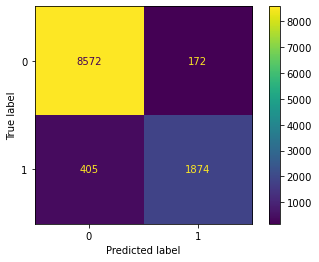

In [54]:
plot_confusion_matrix(final_model_pipeline, X_test['text_cleaned'], y_test)

Let's preview the cases where my model was incorrect.

In [55]:
X_test[y_pred != y_test]

,text_cleaned,text_tokenized_string,title,label,text_pos_lemmatized,text_snowball_stemmed,text_porter_stemmed,text_lancaster_stemmed
44088,side note curious world agree forfeit rainbow ...,side note curious world agree forfeit rainbow ...,AIR FORCE WILL EASE POLICY ON DISCHARGING TRAN...,1,side note curious world agree forfeit rainbow ...,side note curious world agre forfeit rainbow s...,side note curiou world agre forfeit rainbow si...,sid not cury world agr forfeit rainbow sign go...
40550,home world remain supporters instrumental emer...,home world remain supporters instrumental emer...,Remain Supporters Instrumental in Emergence of...,1,home world remain supporter instrumental emerg...,home world remain support instrument emerg eu ...,home world remain support instrument emerg eu ...,hom world remain support instru emerg eu army ...
30018,nail salon tennessee facing uproar woman claim...,nail salon tennessee facing uproar woman claim...,Woman Claims Nail Salon Posted Sign Saying Fat...,0,nail salon tennessee face uproar woman claim p...,nail salon tennesse face uproar woman claim po...,nail salon tennesse face uproar woman claim po...,nail salon ten fac upro wom claim post sign sa...
36861,turkish government blocked access wikipedia on...,turkish government blocked access wikipedia on...,Trump’s Favorite New Dictator Just Cut Off Ac...,1,turkish government block access wikipedia onli...,turkish govern block access wikipedia onlin en...,turkish govern block access wikipedia onlin en...,turk govern block access wikiped onlin encyclo...
38858,appropriate plaque mention obamaholdersharpton...,appropriate plaque mention obamaholdersharpton...,‘GENTLE GIANT’ MICHAEL BROWN MEMORIAL UNVEILED...,1,appropriate plaque mention obamaholdersharpton...,appropri plaqu mention obamaholdersharpton rac...,appropri plaqu mention obamaholdersharpton rac...,appropry plaqu ment obamaholdersharpton rac wa...
...,...,...,...,...,...,...,...,...
39646,tweet widget tanya golashboza donald trump rhe...,tweet widget tanya golashboza donald trump rhe...,Donald J. Trump’s 10 Point Plan to Put America...,1,tweet widget tanya golashboza donald trump rhe...,tweet widget tanya golashboza donald trump rhe...,tweet widget tanya golashboza donald trump rhe...,tweet widget tany golashboz donald trump rhet ...
43020,think world oyster think top secret hqs secret...,think world oyster think top secret hqs secret...,The Top 10 Places In The World You're NOT Allo...,1,think world oyster think top secret hq secreti...,think world oyster think top secret hqs secret...,think world oyster think top secret hq secret ...,think world oyst think top secret hqs secret u...
37552,posted dcg comment abc news least people kille...,posted dcg comment abc news least people kille...,Comment on Guess what happened in Chiraq this ...,1,post dcg comment abc news least people kill in...,post dcg comment abc news least peopl kill inj...,post dcg comment abc news least peopl kill inj...,post dcg com abc new least peopl kil ind chica...
40060,us great enemy mankind raved ernesto che gueva...,us great enemy mankind raved ernesto che gueva...,HOW THE FBI Cracked A Terror Plot On Black Fri...,1,us great enemy mankind rave ernesto che guevar...,us great enemi mankind rave ernesto che guevar...,us great enemi mankind rave ernesto che guevar...,us gre enemy mankind rav ernesto che guevar hy...


Let's work on extracting my features and their respective importance.

In [56]:
final_model_pipeline['Passive Aggressive Classifier'].__dict__

{'loss': 'hinge',
 'penalty': None,
 'learning_rate': 'optimal',
 'epsilon': 0.1,
 'alpha': 0.0001,
 'C': 0.1,
 'l1_ratio': 0.15,
 'fit_intercept': True,
 'shuffle': True,
 'random_state': None,
 'verbose': 0,
 'eta0': 1.0,
 'power_t': 0.5,
 'early_stopping': False,
 'validation_fraction': 0.1,
 'n_iter_no_change': 5,
 'warm_start': False,
 'average': False,
 'max_iter': 100,
 'tol': 0.001,
 'class_weight': None,
 'n_jobs': None,
 'n_features_in_': 5006240,
 'coef_': array([[0.18230928, 0.        , 0.00802201, ..., 0.0425385 , 0.        ,
         0.        ]]),
 'intercept_': array([0.21574599]),
 't_': 656257.0,
 'classes_': array(['0', '1'], dtype='<U1'),
 '_expanded_class_weight': array([1., 1.]),
 'loss_function_': <sklearn.linear_model._sgd_fast.Hinge at 0x219adbd8df0>,
 'n_iter_': 24}

Now let's match up the coefficients with their features.

In [57]:
final_model_pipeline['Passive Aggressive Classifier'].coef_.shape

(1, 5006240)

In [58]:
len(final_model_pipeline['Vectorizer'].get_feature_names())

5006240

In [59]:
type(final_model_pipeline['Passive Aggressive Classifier'].coef_)

numpy.ndarray

In [60]:
type(final_model_pipeline['Vectorizer'].get_feature_names())

list

In [61]:
coefficients_list = final_model_pipeline['Passive Aggressive Classifier'].coef_.tolist()[0]
feature_names_list = final_model_pipeline['Vectorizer'].get_feature_names()

Let's look at the positive features that more strongly predict if an article is fake, with the strongest predictors at the top:

In [62]:
interpretation = tuple(zip(coefficients_list,feature_names_list))
sorted(interpretation, key = lambda x: (-x[0],x[1]))

[(6.747377135890909, 'hillary'),
 (3.8408316658821975, 'screen capture'),
 (3.428729276356939, 'america'),
 (3.198810802474758, 'screenshot'),
 (3.1664177528375683, 'however'),
 (2.976790426622145, 'fact'),
 (2.9401795335528567, 'share'),
 (2.92138101972684, 'snip'),
 (2.911412586375007, 'photo'),
 (2.8977778300975126, 'actually'),
 (2.85272245762393, 'dc'),
 (2.8335652848062005, 'fbi'),
 (2.7851529579746828, 'capture'),
 (2.7803201737980516, 'century'),
 (2.701706640878169, 'realdonaldtrump'),
 (2.6345101306095313, 'entire'),
 (2.561270922861244, 'century says'),
 (2.5556076574284434, 'president obama'),
 (2.548308349055931, 'yearold'),
 (2.5392322041949003, 'gop'),
 (2.506332323711607, 'decided'),
 (2.504122101384248, 'even'),
 (2.4992890038847424, 'apparently'),
 (2.478596240675029, 'clearly'),
 (2.45962707532034, 'went'),
 (2.456264680180934, 'entire story'),
 (2.430141738604795, 'saidthe'),
 (2.3897827555660185, 'wfb'),
 (2.375874830257386, 'news century'),
 (2.3669811476674933, '

Now let's do this for the features that strongly predict if an article is real:

In [63]:
sorted(interpretation)

[(-7.944347504854822, 'president donald'),
 (-5.554356665670556, 'pic'),
 (-4.552567534665306, 'statement'),
 (-4.107982528625238, 'added'),
 (-3.4217345012010547, 'milo'),
 (-3.2909070369753897, 'us president'),
 (-3.210338323301289, 'spokesman'),
 (-2.974949775959213, 'reporters'),
 (-2.8552422270341666, 'president barack'),
 (-2.790528412050684, 'islamic state'),
 (-2.752478667697438, 'democratic'),
 (-2.6986365484641155, 'minister'),
 (-2.6941359804813683, 'whether'),
 (-2.6930153905106766, 'key pamkeynen'),
 (-2.6930153905106766, 'pam key'),
 (-2.6930153905106766, 'pamkeynen'),
 (-2.647901567802225, 'presidential'),
 (-2.6455509656639693, 'president'),
 (-2.6428515849115475, 'republican'),
 (-2.618313803985488, 'pam'),
 (-2.6020281866731785, 'saying'),
 (-2.5550687642738525, 'adding'),
 (-2.435941352795407, 'wrote'),
 (-2.432981142276007, 'spokeswoman'),
 (-2.366934700061129, 'london'),
 (-2.312013335127929, 'agency'),
 (-2.223181127138331, 'last year'),
 (-2.20835798456007, 'amon